The dataset used in this paper is an open source dataset, the source of the dataset is kaggle, the dataset is the brain edema image data, the image format is png, and it contains two folders, the first folder saves the CT images of the brain edema, and the second folder is the image segmentation mask of the brain edema part. The dataset contains 3064 pairs of MRI brain images and their respective binary masks indicative of the tumor, which belongs to the field of medical images and can be used to test the segmentation effectiveness of image segmentation models.

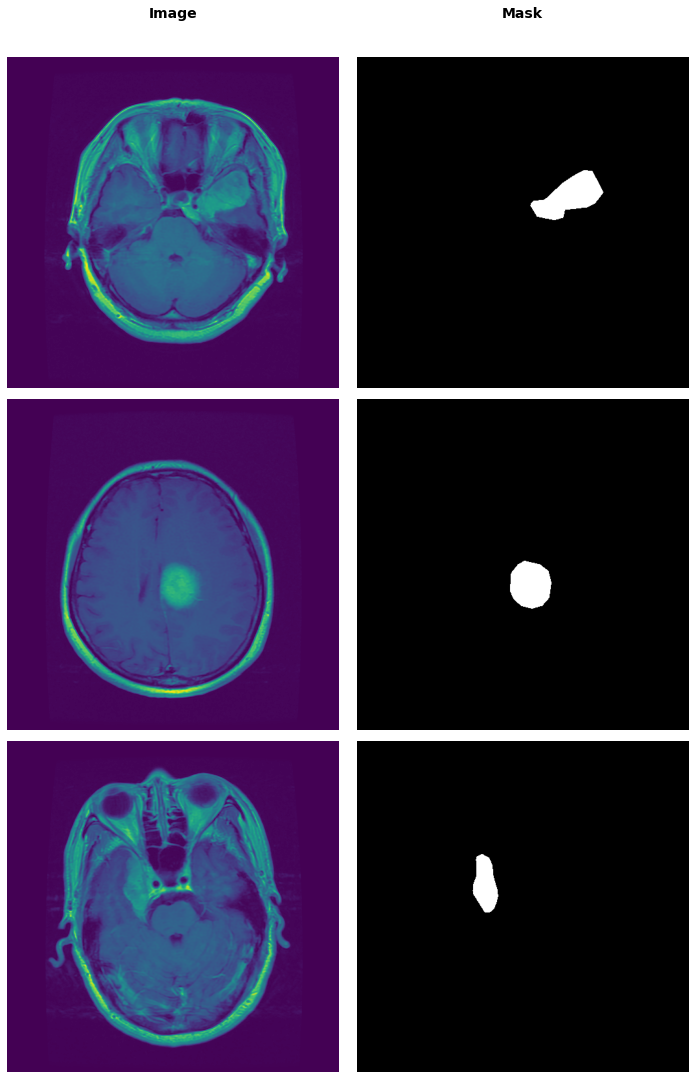

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os

image_dir = r'F:\Brain\images'  
mask_dir = r'F:\Brain\masks'    

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                     if not f.startswith('.')])[:3]  
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) 
                    if not f.startswith('.')])[:3]

fig, axes = plt.subplots(3, 2, figsize=(10, 15))
plt.subplots_adjust(wspace=0.05, hspace=0.05)  

for ax in axes.flat:
    ax.axis('off')

axes[0, 0].set_title('Image', y=1.1, fontsize=14, fontweight='bold')
axes[0, 1].set_title('Mask', y=1.1, fontsize=14, fontweight='bold')

for row in range(3):
    img = Image.open(image_files[row])
    axes[row, 0].imshow(img)
  
    mask = Image.open(mask_files[row])
    axes[row, 1].imshow(mask, cmap='gray') 

plt.tight_layout()
plt.show()

First, we output the original image and its mask, taking the first three images to show. The left side is the original image and the right side is the corresponding mask.

In [7]:
import os
from PIL import Image
import pydicom

def analyze_images(folder_path):
    image_count = 0
    first_size = None

    for root, _, files in os.walk(folder_path):
        for file in files:
            if first_size is not None:
                break
            file_path = os.path.join(root, file)
            try:
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    with Image.open(file_path) as img:
                        first_size = img.size
                        image_count += 1
                elif file_path.lower().endswith('.dcm'):
                    dicom = pydicom.dcmread(file_path)
                    if hasattr(dicom, 'Rows') and hasattr(dicom, 'Columns'):
                        first_size = (dicom.Rows, dicom.Columns)
                        image_count += 1
            except Exception:
                continue
        if first_size is not None:
            break

    print(f"Total number of images: {image_count}")
    if first_size:
        print(f"Size: {first_size}")
analyze_images(image_dir)

Total number of images: 1
Size: (512, 512)


We statistically analyzed the size of the images and learned that each image is composed of 512 x 512 pixels, which matches the format that the model is able to handle without the need for cropping and rotation.

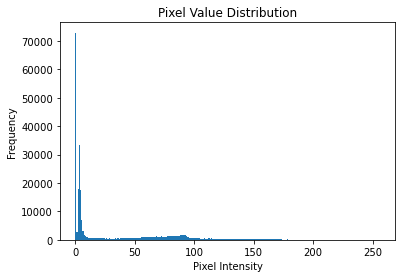

In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

folder_path = image_dir
for file in os.listdir(folder_path):
    if file.lower().endswith('.png'):
        img = Image.open(os.path.join(folder_path, file))
        plt.hist(np.array(img).ravel(), bins=256, range=(0, 256))
        plt.title('Pixel Value Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.show()
        break

We output the histogram of the image for subsequent image enhancement studies. From the histogram, it is clear that the dataset used in this experiment has potential for further image enhancement.

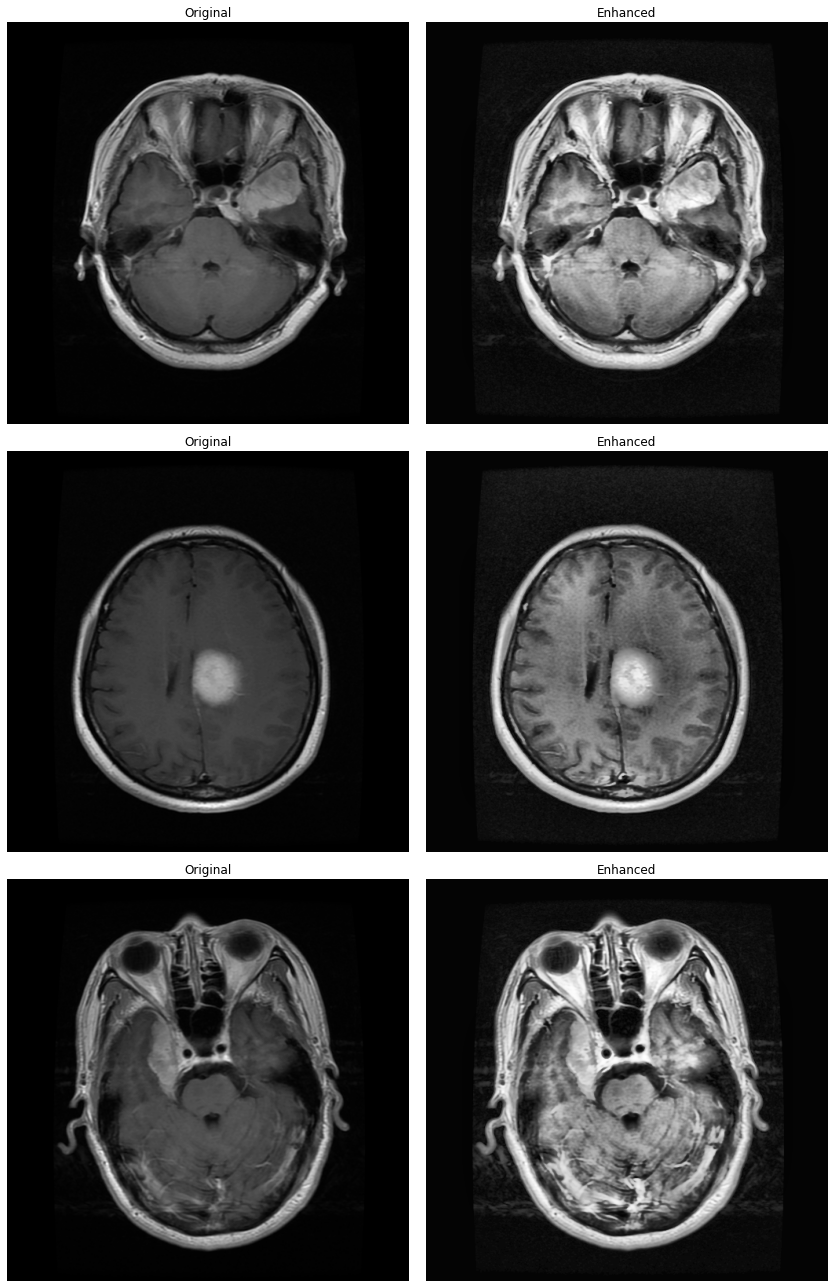

In [10]:
import os
import matplotlib.pyplot as plt
from skimage import exposure, io

folder_path =  image_dir
count = 0

plt.figure(figsize=(12, 18))

for file in sorted(os.listdir(folder_path)):
    if file.lower().endswith('.png') and count < 3:
        img_path = os.path.join(folder_path, file)
        img = io.imread(img_path, as_gray=True)
      
        enhanced = exposure.equalize_adapthist(img, clip_limit=0.02, 
                                             kernel_size=(64,64))
      
        plt.subplot(3, 2, count*2 + 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original')
        plt.axis('off')
      
        plt.subplot(3, 2, count*2 + 2)
        plt.imshow(enhanced, cmap='gray')
        plt.title('Enhanced')
        plt.axis('off')bb
      
        count += 1

plt.tight_layout()
plt.show()

We use histogram equalization for image enhancement with the aim of enhancing the contrast of the lesion region.
Histogram equalization is a classical image enhancement technique that is mainly used to improve the global contrast of an image. Its core principle is to extend the gray level distribution, which is originally concentrated in a narrow interval, to a wider range by redistributing the pixel gray level values. The method first counts the grayscale histogram of the original image, calculates the cumulative distribution function (CDF) of each grayscale level, and then maps the original grayscale values to the new uniformly distributed interval according to the CDF. This nonlinear transformation can effectively enhance dark or bright details, which is especially suitable for medical images, low exposure photos and other scenes with insufficient contrast.

In [11]:
import os
import numpy as np
from skimage import io, color, filters

folder_path = image_dir
count = 0

for file in sorted(os.listdir(folder_path)):
    if file.lower().endswith('.png') and count < 3:
        img_path = os.path.join(folder_path, file)
        image = io.imread(img_path)
        if image.ndim == 3:
            image = color.rgb2gray(image)
        noise_var = np.var(filters.laplace(image))
        print(f"Image: {file} \tNoise Detected: {'Yes' if noise_var > 100 else 'No'}") 
        count += 1

Image: 1.png 	Noise Detected: No
Image: 10.png 	Noise Detected: No
Image: 100.png 	Noise Detected: No


Then we perform noise detection on the image and after checking there is no noise and no need to denoise the image.

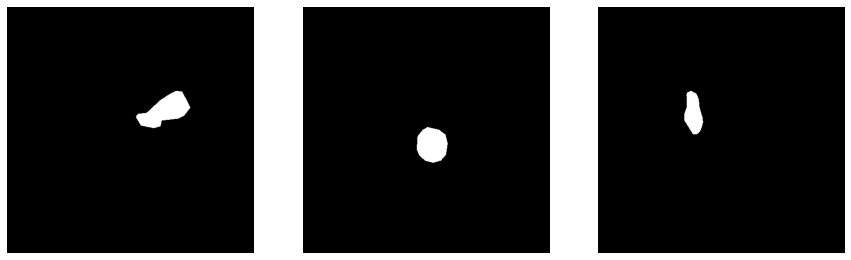

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image

folder = mask_dir
files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
outputs = []

for idx, file in enumerate(files):
    img = Image.open(os.path.join(folder, file)).convert('L')
    binary = img.point(lambda x: 1 if x > 127 else 0, '1')
    outputs.append(binary)
    if idx == 2:
        break

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(outputs[i], cmap='gray')
    plt.axis('off')
plt.show()

We perform binarization and convert each pixel into either 0 or 1 based on a fixed threshold of 127. Specifically, any pixel with an intensity greater than 127 is set to 1 (white), representing the foreground, while others are set to 0 (black), representing the background. The resulting binary masks are then displayed for visual inspection.

The threshold value of 127 is commonly used because it is the midpoint of the 8-bit grayscale range (0–255). It provides a simple and effective way to separate brighter areas (usually the object or region of interest) from darker backgrounds, especially when dealing with masks already close to binary.

However, in more complex situations—such as when the image has poor contrast, uneven lighting, or is not clearly bimodal—using a fixed threshold like 127 may not yield good results. In such cases, more advanced thresholding methods are recommended:

Otsu's method: Automatically determines an optimal threshold by minimizing intra-class variance. Best for images with a clear distinction between foreground and background.

Adaptive thresholding: Applies different thresholds to different regions of the image, useful when lighting is uneven across the image.

Clustering methods (e.g., k-means): Group pixel intensities into clusters and assign binary labels accordingly, useful for complex or noisy images.

In summary, while 127 is a reasonable default for simple, high-contrast masks, other thresholding techniques may provide better segmentation results in more challenging scenarios.